In [1]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
from scipy.io import loadmat
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

In [2]:
#get coordinates of sensors
def get_coordinates():
    layout_filename = '/Users/anna/Downloads/decoding-the-human-brain/Vectorview-all.lay'
    X = np.loadtxt(layout_filename, usecols=(1,), delimiter='\t', dtype='S')
    Y = np.loadtxt(layout_filename, usecols=(2,), delimiter='\t', dtype='S')
    
    channel_name = np.loadtxt(layout_filename, usecols=(5,), delimiter='\t', dtype='S')
   
    mag_indexes = np.array([str(cn)[-2]=='1' for cn in channel_name], dtype=np.bool)
    #take magnitometers raws
    X_mag = X[mag_indexes]
    Y_mag = Y[mag_indexes]
        
    #take gradiometers indexes
    grad_indexes = [not i for i in mag_indexes]
    #take gradiometers raws
    X_grad = X[grad_indexes]
    Y_grad = Y[grad_indexes]

    return X_mag, Y_mag, X_grad, Y_grad

In [3]:
#get mag and grad faces and 
def get_channels_from_subjects():
    #get channels for the first subject
    sub = 1
    mag_face, mag_scrambled, grad_face, grad_scrambled = get_channels(sub)
    #concatenation of 6 subjects (from 1 to 6)
    for sub in range(2, 7):
        mag_face_i, mag_scrambled_i, grad_face_i, grad_scrambled_i = get_channels(sub)
        mag_face = np.concatenate((mag_face, mag_face_i), axis=1)
        mag_scrambled = np.concatenate((mag_scrambled, mag_scrambled_i), axis=1)
        grad_face = np.concatenate((grad_face, grad_face_i), axis=1)
        grad_scrambled = np.concatenate((grad_scrambled, grad_scrambled_i), axis=1)
    return mag_face, mag_scrambled, grad_face, grad_scrambled

In [4]:
def get_channels(sub):
    
    subject = sub
    tmin = -0.5 # in sec.
    tmax = 1.0 # in sec.
    cv = 5 # numbers of fold of cross-validation
    filename = '/Users/anna/Downloads/decoding-the-human-brain/data/train_subject%02d.mat' % subject
    layout_filename = '/Users/anna/Downloads/decoding-the-human-brain/Vectorview-all.lay'
    
    data = loadmat(filename, squeeze_me=True)
    X = data['X']
    y = data['y']
    sfreq = data['sfreq']
    
    time = np.linspace(-0.5, 1.0, 375)
    time_window = np.logical_and(time >= tmin, time <= tmax)
    X = X[:,:,time_window]
    time = time[time_window]
    
    channel_name = np.loadtxt(layout_filename, usecols=(5,), delimiter='\t', dtype='S')
   
    mag_indexes = np.array([str(cn)[-2]=='1' for cn in channel_name], dtype=np.bool)
    #take magnitometers raws
    mag = X[:,mag_indexes,:]
    
    #take gradiometers indexes
    grad_indexes = [not i for i in mag_indexes]
    #take gradiometers raws
    grad = X[:,grad_indexes,:]

    #normalisation of matrices at all time points for array of gradiomneters
    mag_prep = scaling(mag)
    #normalisation of matrices at all time points for array of magnitometers
    grad_prep = scaling(grad)

    face_indexes = np.array([i == 1 for i in y], dtype=np.bool)
    #take faces columns
    mag_face = mag_prep[:,face_indexes,:]
    #take faces columns
    grad_face = grad_prep[:,face_indexes,:]

    #take scrambled faces indexes
    scrambled_face_indexes = [not i for i in face_indexes]
    mag_scrambled = mag_prep[:,scrambled_face_indexes,:]
    grad_scrambled = grad_prep[:,scrambled_face_indexes,:]

    return mag_face, mag_scrambled, grad_face, grad_scrambled

In [5]:
#input = mag or grad array
def scaling(X):
    
    t0 = X[:,:,0]
    t0t = np.swapaxes(t0,0,1)
    t0t_scale = preprocessing.scale(t0t, axis = 0) 

    for i in range(1,375):
        t = X[:,:,i]
        tt = np.swapaxes(t,0,1)
        tt_scale = preprocessing.scale(tt, axis = 0)
        t0t_scale = np.dstack([t0t_scale, tt_scale])

    return t0t_scale

In [6]:
#compute tranformation matrix between pattern matrices X and Y 
#when regularisation parameter lambda is equal l
def compute_T(X,Y,l):
    Xtrans = X.T
    #changed inv to pinv(Moore-Penrose pseudoinverse) 
    p = np.linalg.pinv(np.dot(X,Xtrans)+l*np.eye(X.shape[0]))# Nx size
    T = np.dot((np.dot(Y,Xtrans)),p)
    return T

In [7]:
#it should be faster than sum of residuals
#def sum_of_residuals(X,Y,l):
def compute_lambda(X,Y,l):
    Xtrans = X.T
    inner_part = np.dot(X,Xtrans)+l*np.eye(X.shape[0])
    H = np.dot(np.dot(Xtrans, np.linalg.pinv(inner_part)),X)
    #addition matrix that change all elementa
    A_tmp = 1/(1-H)
    A = np.diag(A_tmp)
    
    #final calculation of lambda function
    Lambda =  (np.linalg.norm(np.dot(np.dot(A,np.eye(X.shape[1])-H),Y.T), ord=2))**2
    return Lambda

In [8]:
#compute sum of residuals 
def sum_of_residuals(X,Y,l):
    s = 0
    #for each column in matrices
    for i in range(0, X.shape[1]):
        
        #take i-th column
        X_i = X[:,i]
        Y_i = Y[:,i]
        
        #take out i-th column
        X_ = np.delete(X, i, 1)
        Y_ = np.delete(Y, i, 1)

        #compute tranformation matrix
        T_a = compute_T(X_,Y_,l)
        #add the ratio between the squared norm of the residual 
        #and of the (left out) MV-pattern (that for normilesed data
        #equals to size of vector Y_i)
        s += (np.linalg.norm((np.dot(T_a,X_i)-Y_i), ord=2))**2/Y_i.shape[0]
    return s

In [9]:
def get_regularisation_parameter(X,Y):
    #let tmp(temporal value) is number that bigger than possible sum of residuals
    tmp = 9999999 
    sum_lambda = 0,1 #pair of numbers 
    a = 0 
    step = 100
    #firstly, compute sum of residuals for each l 
    #from a = 0 to a = 10000 with step 100
    #until sum of residuals more(or equals) than tmp
    for l in np.arange(a, 10000, step):
        
       # s = sum_of_residuals(X, Y, l)
        s = compute_lambda(X, Y, l)
        #if sum of residuals less than tmp
        if (s < tmp):
            tmp = s
            sum_lambda = s, l

        else:
            a -= 2*step
            step /= 2
            
        if (step < 0.01):
            return sum_lambda[1]

In [10]:
def plot_regularisation_parameter(X,Y):
    sum_list = []
    for l in np.arange(50, 10000, 100):
        s = 0
        for i in range(0, X.shape[1]):
            X_i = X[:,i]
            Y_i = Y[:,i]

            X_ = np.delete(X, i, 1)
            Y_ = np.delete(Y, i, 1)

            T_a = compute_T(X_,Y_,l)
            s += (np.linalg.norm((np.dot(T_a,X_i)-Y_i), ord=2))**2/Y_i.shape[0]
        sum_list.append((s,l))
    arr = np.asarray(sum_list)
    plt.plot(arr[:,1], arr[:,0], 'b')
    plt.xlabel('lambda')

In [11]:
def compute_GOF(X, Y, l):
    return 100*(1-sum_of_residuals(X,Y,l)/(Y.shape[0]*Y.shape[1]))
    #return 100*(1-compute_lambda(X,Y,l)/(Y.shape[0]*Y.shape[1])) - here must be only sum of residuals

In [12]:
def get_explained_variance_matrix(X):
    explained_variance = np.zeros((37,37))
    number_of_time_points = X.shape[2] #375 for the first subject
    for i in range(10,number_of_time_points,int(number_of_time_points/37)):
        for j in range(10,number_of_time_points,int(number_of_time_points/37)): 
        
            t0 = X[:,:,i] #matrix X
            t1 = X[:,:,j] #matrix Y = TX
            
            #the defualt regularisation parameter lambda is used here
            l = 2500
            #l = get_regularisation_parameter(t0,t1)

            #T = compute_T(t0,t1,l)#transformation matrix
            
            a = 36-int((number_of_time_points-i)/(number_of_time_points/37)) #calculate index in array
            b = 36-int((number_of_time_points-j)/(number_of_time_points/37))

            explained_variance[a,b] = compute_GOF(t0,t1,l)
    return explained_variance

In [14]:
mag_face, mag_scrambled, grad_face, grad_scrambled = get_channels_from_subjects()

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical i

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [12]:
#new computations with default lambda value

In [21]:
goodness_of_fit_mag_faces = get_explained_variance_matrix(mag_face)

In [23]:
goodness_of_fit_mag_scrambled_faces = get_explained_variance_matrix(mag_scrambled)

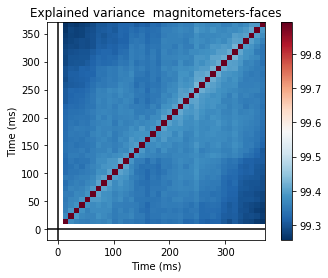

In [22]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(goodness_of_fit_mag_faces, #interpolation='lanczos',
               origin='lower', cmap='RdBu_r',extent=[10, 370, 10, 370])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Time (ms)')
ax.set_title('Explained variance  magnitometers-faces')
ax.axvline(0, color='k')
ax.axhline(0, color='k')

plt.colorbar(im, ax=ax)

In [24]:
goodness_of_fit_mag_faces.shape

(37, 37)

In [25]:
goodness_of_fit_mag_scrambled_faces

array([[99.88941798, 99.3767984 , 99.36794659, ..., 99.27563305,
        99.26787499, 99.25966727],
       [99.38038323, 99.89031413, 99.38333877, ..., 99.28166485,
        99.27821948, 99.26735748],
       [99.36149006, 99.37634085, 99.89005646, ..., 99.27892918,
        99.27326456, 99.27040496],
       ...,
       [99.26612332, 99.266411  , 99.27079709, ..., 99.89012022,
        99.3945945 , 99.3791229 ],
       [99.26086521, 99.25943373, 99.26742626, ..., 99.39798006,
        99.88994987, 99.38577541],
       [99.25180299, 99.25237632, 99.26264684, ..., 99.38558202,
        99.39203569, 99.89008073]])

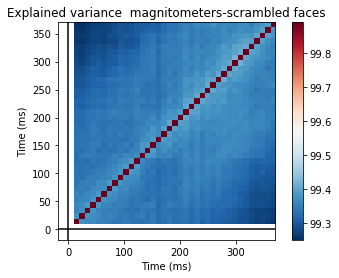

In [26]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(goodness_of_fit_mag_scrambled_faces, #interpolation='lanczos',
              origin='lower', cmap='RdBu_r',extent=[10, 370, 10, 370])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Time (ms)')
ax.set_title('Explained variance  magnitometers-scrambled faces')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
plt.colorbar(im, ax=ax)

In [27]:
goodness_of_fit_grad_faces = get_explained_variance_matrix(grad_face)

In [15]:
goodness_of_fit_grad_scrambled_faces = get_explained_variance_matrix(grad_scrambled)

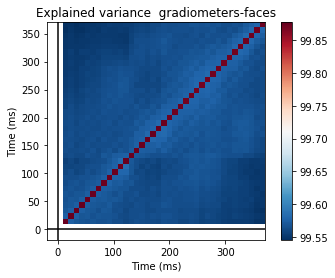

In [28]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(goodness_of_fit_grad_faces, #interpolation='lanczos',
               origin='lower', cmap='RdBu_r',extent=[10, 370, 10, 370])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Time (ms)')
ax.set_title('Explained variance  gradiometers-faces')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
plt.colorbar(im, ax=ax)

fig, ax = plt.subplots(1, 1)
im = ax.imshow(goodness_of_fit_grad_faces, #interpolation='lanczos',
               origin='lower', cmap='RdBu_r')
ax.set_xlabel('Time')
ax.set_ylabel('Time')
ax.set_title('Explained variance  gradiometers-faces')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
plt.colorbar(im, ax=ax)

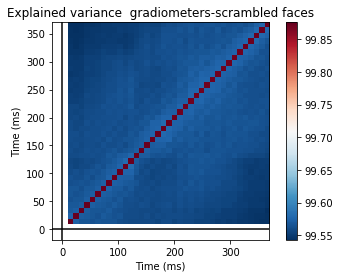

In [16]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(goodness_of_fit_grad_scrambled_faces, #interpolation='lanczos',
               origin='lower', cmap='RdBu_r',extent=[10, 370, 10, 370])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Time (ms)')
ax.set_title('Explained variance  gradiometers-scrambled faces')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
plt.colorbar(im, ax=ax)

In [37]:
1

1

In [17]:
gof_mag_face_vs_scrambled  = goodness_of_fit_mag_faces - goodness_of_fit_mag_scrambled_faces

fig, ax = plt.subplots(1, 1)
im = ax.imshow(gof_mag_face_vs_scrambled, #interpolation='lanczos',
               origin='lower', cmap='RdBu_r',extent=[10, 371, 10, 371])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Time (ms)')
ax.set_title('Difference between explained variance for magnitometers')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
plt.colorbar(im, ax=ax)

gof_grad_face_vs_scrambled  = goodness_of_fit_grad_faces - goodness_of_fit_grad_scrambled_faces

fig, ax = plt.subplots(1, 1)
im = ax.imshow(gof_grad_face_vs_scrambled, #interpolation='lanczos',
               origin='lower', cmap='RdBu_r',extent=[10, 370, 10, 370])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Time (ms)')
ax.set_title('Difference between explained variance for gradiometers')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
plt.colorbar(im, ax=ax)

NameError: name 'goodness_of_fit_mag_faces' is not defined

NameError: name 'goodness_of_fit_grad_faces' is not defined

In [152]:
X_grad

array([b'-73.416206', b'-73.416206', b'-59.602242', b'-59.602242',
       b'-68.018288', b'-68.018288', b'-80.582848', b'-80.582848',
       b'-56.595154', b'-56.595154', b'-44.599728', b'-44.599728',
       b'-47.416420', b'-47.416420', b'-59.280643', b'-59.280643',
       b'-39.790501', b'-39.790501', b'-38.014336', b'-38.014336',
       b'-27.679966', b'-27.679966', b'-49.684467', b'-49.684467',
       b'-32.997990', b'-32.997990', b'-21.084751', b'-21.084751',
       b'-21.930935', b'-21.930935', b'-34.824663', b'-34.824663',
       b'-27.861498', b'-27.861498', b'-15.506709', b'-15.506709',
       b'-14.616095', b'-14.616095', b'-27.240477', b'-27.240477',
       b'-14.782405', b'-14.782405', b'-2.967276', b'-2.967276',
       b'-9.094766', b'-9.094766', b'-15.199021', b'-15.199021',
       b'-9.246834', b'-9.246834', b'3.314525', b'3.314525', b'3.387173',
       b'3.387173', b'-9.422897', b'-9.422897', b'-2.962408',
       b'-2.962408', b'-2.965545', b'-2.965545', b'9.504830', b'

In [154]:
mag_face

array([[[ 1.05159342e+00,  2.04427361e+00,  8.29469740e-01, ...,
          2.45526090e-01, -2.02077985e-01, -1.34174272e-01],
        [-2.41282910e-01, -7.49693096e-01, -3.92120212e-01, ...,
          1.63912499e+00,  1.18501496e+00,  2.01375198e+00],
        [-2.71126866e-01, -5.49113490e-02, -1.89572826e-01, ...,
         -1.20615304e+00, -2.30505347e+00, -1.41619205e+00],
        ...,
        [ 5.26346385e-01,  7.75401533e-01,  9.87423062e-01, ...,
          4.44032401e-01,  1.50010788e+00,  1.82210314e+00],
        [-6.92658246e-01, -1.29052472e+00, -1.04802108e+00, ...,
         -7.43756235e-01,  1.42004425e-02,  1.01677763e+00],
        [-6.71288133e-01, -4.01031941e-01, -8.63421440e-01, ...,
          2.93877101e+00,  1.02436483e+00,  1.50251424e+00]],

       [[ 4.39292133e-01, -9.24619287e-03, -3.02277744e-01, ...,
          3.10040236e-01, -1.01429177e-02,  1.89540714e-01],
        [-3.29710603e-01, -6.17243767e-01,  7.04861343e-01, ...,
          1.28196776e+00,  7.66992807e

In [137]:
X

array([b'-73.416206', b'-73.416206', b'-67.416206', b'-59.602242',
       b'-59.602242', b'-53.602242', b'-68.018288', b'-68.018288',
       b'-62.018288', b'-80.582848', b'-80.582848', b'-74.582848',
       b'-56.595154', b'-56.595154', b'-50.595154', b'-44.599728',
       b'-44.599728', b'-38.599728', b'-47.416420', b'-47.416420',
       b'-41.416420', b'-59.280643', b'-59.280643', b'-53.280643',
       b'-39.790501', b'-39.790501', b'-33.790501', b'-38.014336',
       b'-38.014336', b'-32.014336', b'-27.679966', b'-27.679966',
       b'-21.679966', b'-49.684467', b'-49.684467', b'-43.684467',
       b'-32.997990', b'-32.997990', b'-26.997990', b'-21.084751',
       b'-21.084751', b'-15.084751', b'-21.930935', b'-21.930935',
       b'-15.930935', b'-34.824663', b'-34.824663', b'-28.824663',
       b'-27.861498', b'-27.861498', b'-21.861498', b'-15.506709',
       b'-15.506709', b'-9.506709', b'-14.616095', b'-14.616095',
       b'-8.616095', b'-27.240477', b'-27.240477', b'-21.240477

In [131]:
Y

array([b'33.416687', b'38.416687', b'35.916687', b'38.489067',
       b'43.489067', b'40.989067', b'18.676970', b'23.676970',
       b'21.176970', b'8.095787', b'13.095787', b'10.595787',
       b'17.019251', b'22.019251', b'19.519251', b'17.543873',
       b'22.543873', b'20.043873', b'-0.216784', b'4.783216', b'2.283216',
       b'-2.761772', b'2.238228', b'-0.261772', b'47.430138',
       b'52.430138', b'49.930138', b'32.768585', b'37.768585',
       b'35.268585', b'28.868065', b'33.868065', b'31.368065',
       b'34.078434', b'39.078434', b'36.578434', b'15.607347',
       b'20.607347', b'18.107347', b'13.953575', b'18.953575',
       b'16.453575', b'-0.085500', b'4.914500', b'2.414500', b'0.362587',
       b'5.362587', b'2.862587', b'55.439636', b'60.439636', b'57.939636',
       b'59.619865', b'64.619865', b'62.119865', b'49.308380',
       b'54.308380', b'51.808380', b'43.863430', b'48.863430',
       b'46.363430', b'38.147827', b'43.147827', b'40.647827',
       b'27.260933', b

In [ ]:
#old computations

In [17]:
goodness_of_fit_mag_faces = get_explained_variance_matrix(mag_face)

In [18]:
goodness_of_fit_mag_scrambled_faces = get_explained_variance_matrix(mag_scrambled)

In [19]:
goodness_of_fit_grad_faces = get_explained_variance_matrix(grad_face)

In [20]:
goodness_of_fit_grad_scrambled_faces = get_explained_variance_matrix(grad_scrambled)

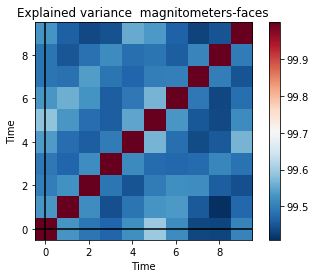

In [23]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(goodness_of_fit_mag_faces, #interpolation='lanczos',
               origin='lower', cmap='RdBu_r')
ax.set_xlabel('Time')
ax.set_ylabel('Time')
ax.set_title('Explained variance  magnitometers-faces')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
plt.colorbar(im, ax=ax)

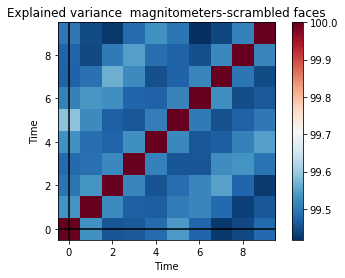

In [24]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(goodness_of_fit_mag_scrambled_faces, #interpolation='lanczos',
               origin='lower', cmap='RdBu_r')
ax.set_xlabel('Time')
ax.set_ylabel('Time')
ax.set_title('Explained variance  magnitometers-scrambled faces')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
plt.colorbar(im, ax=ax)

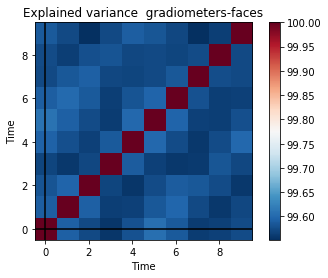

In [21]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(goodness_of_fit_grad_faces, #interpolation='lanczos',
               origin='lower', cmap='RdBu_r')
ax.set_xlabel('Time')
ax.set_ylabel('Time')
ax.set_title('Explained variance  gradiometers-faces')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
plt.colorbar(im, ax=ax)

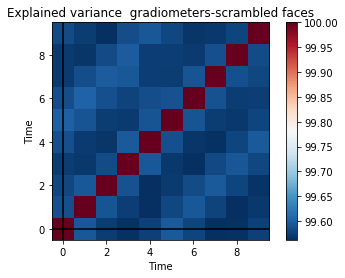

In [22]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(goodness_of_fit_grad_scrambled_faces, #interpolation='lanczos',
               origin='lower', cmap='RdBu_r')
ax.set_xlabel('Time')
ax.set_ylabel('Time')
ax.set_title('Explained variance  gradiometers-scrambled faces')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
plt.colorbar(im, ax=ax)

In [25]:
gof_mag_face_vs_scrambled  = goodness_of_fit_mag_faces - goodness_of_fit_mag_scrambled_faces

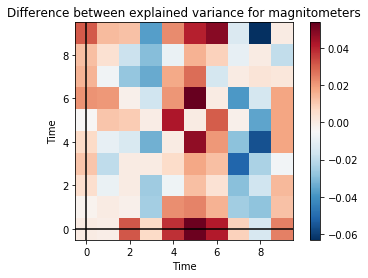

In [26]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(gof_mag_face_vs_scrambled, #interpolation='lanczos',
               origin='lower', cmap='RdBu_r')
ax.set_xlabel('Time')
ax.set_ylabel('Time')
ax.set_title('Difference between explained variance for magnitometers')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
plt.colorbar(im, ax=ax)

In [27]:
gof_grad_face_vs_scrambled  = goodness_of_fit_grad_faces - goodness_of_fit_grad_scrambled_faces

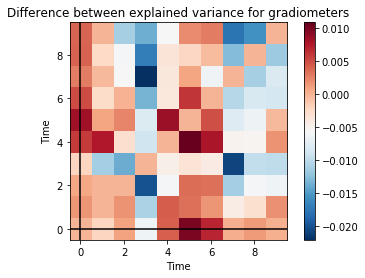

In [28]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(gof_grad_face_vs_scrambled, #interpolation='lanczos',
               origin='lower', cmap='RdBu_r')
ax.set_xlabel('Time')
ax.set_ylabel('Time')
ax.set_title('Difference between explained variance for gradiometers')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
plt.colorbar(im, ax=ax)